<a href="https://colab.research.google.com/github/katehee/X-ray_pneumonia_classification/blob/master/pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title libraries
from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
from numpy import asarray
import seaborn as sns
from tqdm import tqdm

import tensorflow as tf
from keras.preprocessing import image
from keras.utils.data_utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.tensorflow import balanced_batch_generator
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report,confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

from keras.applications.resnet import ResNet50
from keras.applications.densenet import DenseNet121
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.applications.mobilenet_v3 import MobileNetV3
from keras import models

drive.mount('/content/drive')

Mounted at /content/drive


#Import data

In [2]:
train_dir = "/content/drive/MyDrive/Pneumonia/train/"
test_dir = "/content/drive/MyDrive/Pneumonia/test/"
val_dir = "/content/drive/MyDrive/Pneumonia/val/"

#images to 3d-array 
def img_to_array(dir, label, img_size = 128): 
  image_path = dir + str(label.upper()) #folder name is in upper case 
  image_files = os.listdir(os.path.join(dir, str(label.upper())))
  
  #converting pneumonia/normal images to array 
  images = []
  b_images, v_images = [], [] 
  for image_file in tqdm(image_files): 
    image = cv2.imread(os.path.join(image_path, image_file))
    image = cv2.resize(image, (img_size, img_size)) 
    image = image / 255. 
    images.append(image)

    if label == 'pneumonia': 
      if image_file.split('_')[1] == 'bacteria': 
        b_images.append(image)
      elif image_file.split('_')[1] == 'virus': 
        v_images.append(image)
    
  if label == 'normal': 
    return np.array(images)
  
  elif label == 'pneumonia': 
    return np.array(images), np.array(b_images), np.array(v_images)

In [3]:
#convert train images to 3d arrays 
print("===========training set===========")
p_train, b_train, v_train = img_to_array(train_dir, 'pneumonia')
n_train = img_to_array(train_dir, 'normal')
print("normal: ", n_train.shape, "pneumonia:",p_train.shape, "bateria:", b_train.shape, "virus:",v_train.shape)

#convert validation images to 3d arrays 
print("===========validation set===========")
p_val, b_val, v_val = img_to_array(val_dir, 'pneumonia')
n_val = img_to_array(val_dir, 'normal')
print("normal: ", n_val.shape, "pneumonia:",p_val.shape, "bateria:", b_val.shape, "virus:",v_val.shape)

#convert test images to 3d arrays 
print("===========test set===========")
p_test, b_test, v_test = img_to_array(test_dir, 'pneumonia')
n_test = img_to_array(test_dir, 'normal')
print("normal: ", n_test.shape, "pneumonia:",p_test.shape, "bateria:", b_test.shape, "virus:", v_test.shape)

===========training set===========


100%|██████████| 1359/1359 [01:36<00:00, 14.15it/s]


normal:  (1359, 128, 128, 3) pneumonia: (3933, 128, 128, 3) bateria: (2561, 128, 128, 3) virus: (1372, 128, 128, 3)
===========validation set===========


100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


normal:  (8, 128, 128, 3) pneumonia: (8, 128, 128, 3) bateria: (8, 128, 128, 3) virus: (0,)
===========test set===========


100%|██████████| 234/234 [00:21<00:00, 10.93it/s]

normal:  (234, 128, 128, 3) pneumonia: (390, 128, 128, 3) bateria: (242, 128, 128, 3) virus: (148, 128, 128, 3)


#EDA

In [ ]:
num_pneumonia = len(p_train)
num_normal = len(n_train)

x = ['pneumonia','normal']
y1 = [len(b_train), len(n_train)]
y2 = [len(v_train), 0]

#bar-chart pneumonia vs normal 
fig, ax =  plt.subplots(figsize = (5, 5))
ax.bar(x, y1, color = ('#b22222', '#004c70'))
ax.bar(x, y2, color = ('#b55e5e', '#004c70'), bottom=y1)
for s in ["top","right"]:
    ax.spines[s].set_visible(False)

#annotate y-value
# for bar in ax.patches: 
#   print(bar)
#   ax.annotate(f"{bar.get_height():.0f}", 
#                    xy = (bar.get_x() + bar.get_width() / 2., bar.get_height()), 
#                    ha = 'center', va = 'center', 
#                    xytext = (0, 7), 
#                    textcoords = 'offset points')
# x=axis tick
plt.xticks(fontsize=14)
# y-axis tick
plt.yticks(fontsize=14)
grid_y_ticks = np.arange(0, 5100, 1000)
ax.set_yticks(grid_y_ticks)
ax.grid(axis='y', linestyle='-', alpha=0.3)

ax.text(0, 1400, "Bacteria \n (2561)\n 65.1%", ha='center', va='center', size=13)
ax.text(0, 3200, "Virus\n (1372)\n 34.9%", ha='center', va='center', size=13)
ax.text(0, 4150, "3933", ha='center', va='center', size=14)
ax.text(0.89, 1500, "1359", size=14)

ax.set_title('Number of each class sample', fontsize=15, fontweight='bold')
ax.set_ylabel('Number of samples', fontsize=14)
plt.show()

In [ ]:
#@title show_images function
#sample images from each class
def show_images(dir, label, size): 
  image_names = os.listdir(os.path.join(dir, label))
  selected_images = random.sample(image_names, size*size) #random select 

  plt.figure(figsize=(6,6))
  for i in range(size*size): 
    plt.subplot(size, size, i + 1)
    image = cv2.imread(os.path.join(os.path.join(dir, label), selected_images[i]))
    plt.imshow(image)
    plt.axis('off')
  plt.tight_layout(pad=0.5)


In [ ]:
show_images(train_dir, label="PNEUMONIA", size=4) #generate size * size image plot 

In [ ]:
show_images(train_dir, label="NORMAL", size=4)

### Average image

In [ ]:
#@title

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def average_img(images_list, label, size = (128,128,3)):
    # calculate the average
    avg_img = np.mean(images_list, axis = 0)
    # reshape
    avg_img = avg_img.reshape(size)
    plt.imshow(avg_img, cmap='Greys_r', vmin=0, vmax=255) 
    plt.title(f'Average {label.lower()}')
    plt.colorbar()
    plt.axis('off')
    plt.show()
    return rgb2gray(avg_img)

norm_mean = average_img(n_train, 'NORMAL')
pneu_mean = average_img(p_train, 'PNEUMONIA')
#pneumonia X-rays tend to show higher obstruction around the chest area.

###Contrast

In [ ]:
#@title
contrast_mean = norm_mean - pneu_mean
plt.imshow(contrast_mean, cmap='RdBu')
plt.title(f'Difference Between Normal and Pneumonia average')
plt.axis('off')
plt.show()
#red indicates the most different areas in dark color 
#blue indicates the most different areas in light color 

### standard deviation 

In [ ]:
#@title
def std_img(images_list, label, size = (128,128,3)):
    # calculate the average
    avg_img = np.std(images_list, axis = 0)
    # reshape it back to a matrix
    avg_img = avg_img.reshape(size)
    plt.imshow(avg_img, cmap='gray', vmin=0, vmax=255) 
    plt.title(f'Average {label.lower()} image')
    plt.axis('off')
    plt.show()
    return avg_img

norm_std = std_img(n_train, 'NORMAL')
pneu_std = std_img(p_train, 'PNEUMONIA')

#there are larger areas of variance found in pneumonia lung 

#Image preprocessing

In [6]:
img_size = 128
batch_size = 32
epoch_size = 15

train_datagen = ImageDataGenerator(
        rotation_range = 10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1)  # randomly shift images vertically (fraction of total height)

test_datagen = ImageDataGenerator()


### Augmented Data

In [7]:
#normal vs pneumonia 
x_train = np.concatenate((p_train, n_train))
y_train = np.concatenate((np.ones(len(p_train)), np.zeros(len(n_train)))) #label [0,1] == [normal, pneumonia]
x_val = np.concatenate((p_val, n_val))
y_val = np.concatenate((np.ones(len(p_val)), np.zeros(len(n_val))))
x_test = np.concatenate((p_test, n_test))
y_test = np.concatenate((np.ones(len(p_test)), np.zeros(len(n_test)))) 

aug_train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)

### Balanced Augmented Data

In [8]:
#balanced augmented data 
#current image dataset is an imbalanced dataset approx. ratio is 3:1 (pneumonia: normal)
#to balance out the data, I applied oversampling which will increase the size of normal images as the size of pneumonia 

#flatten three channels of each image to one array 
reshaped_x_train = x_train.reshape(x_train.shape[0],-1) 

#oversampling
oversample = RandomOverSampler()
oversampled_X, oversampled_y  = oversample.fit_resample(reshaped_x_train , y_train)

# reshaping X back to the first dims
oversampled_X = oversampled_X.reshape(-1,img_size,img_size,3)

print("imbalanced x_train had {} pneumonia and {} normal samples".format(len(p_train), len(n_train)))
print("balanced set now has {} pneumonia and {} normal samples".format(int(sum(oversampled_y)), int(len(oversampled_X) - sum(oversampled_y))))

balanced_train_generator = train_datagen.flow(oversampled_X, oversampled_y, batch_size=batch_size)

imbalanced x_train had 3933 pneumonia and 1359 normal samples
balanced set now has 3933 pneumonia and 3933 normal samples


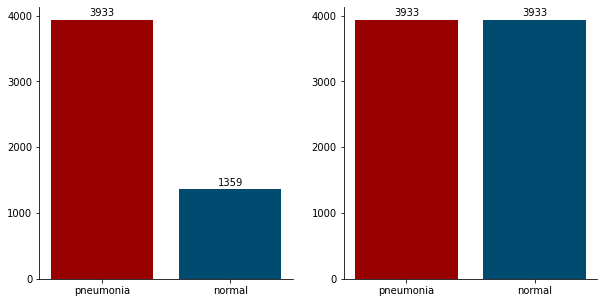

In [9]:
#@title change in number of samples in each class after augmentation and oversampling
y = [[len(p_train), len(n_train)], [int(sum(oversampled_y)),int(len(oversampled_X) - sum(oversampled_y))]]

fig, axes =  plt.subplots(nrows=1,ncols=2 ,figsize = (10, 5))
for i in range(len(y)): 
  axes[i].bar(['pneumonia','normal'], y[i], color = ('#990000', '#004c70'))
  for s in ["top","right"]:
      axes[i].spines[s].set_visible(False)

  #annotate y-value
  for bar in axes[i].patches: 
    axes[i].annotate(f"{bar.get_height():.0f}", 
                    xy = (bar.get_x() + bar.get_width() / 2., bar.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 7), 
                    textcoords = 'offset points')

  # y-axis tick
  grid_y_ticks = np.arange(0, 4400, 1000)
  axes[i].set_yticks(grid_y_ticks)
  # axes[i].grid(axis='y', linestyle='-', alpha=0.3)

### Non-augmented Data

In [10]:
raw_train_generator = test_datagen.flow(x_train, y_train, batch_size=batch_size)

In [11]:
val_generator = test_datagen.flow(x_val, y_val, batch_size=batch_size)
test_generator = test_datagen.flow(x_test, y_test, batch_size=len(x_test), shuffle=False)

##Augmented image sample 

class:  PNEUMONIA


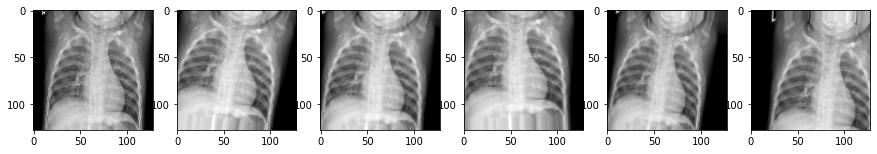

In [12]:
#augmentation of a sample in the training set 
labels =  ['NORMAL','PNEUMONIA']
fig, axes = plt.subplots(1,6,figsize=(15,15))
orig_img = np.array([x_train[0]]) #first image in the training set (original: non-augmented)
axes[0].imshow(orig_img.reshape(img_size,img_size,3), cmap='gray') 
for i in range(5): #display five generated augmented images
  sample, label = train_datagen.flow(orig_img, y_train[:1]).__getitem__(0)
  for img in sample: 
    axes[i+1].imshow(img[:,:,0], cmap='gray')
print("class: ", labels[int(label[0])])

#CNN Modeling

In [13]:
#@title create_plot
def create_plot(model, history, epoch_size): 
    epochs = [i for i in range(epoch_size)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(12,6)

    ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
    ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
    ax[1].set_title('Testing Accuracy & Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")
    plt.show()
    #evaluation metric
    metrics(model)

In [41]:
#@title create_model and lr reduction callback
def create_model(): 
    tf.keras.backend.clear_session()
    model = Sequential()
    model.add(Conv2D(32 , (3,3), activation = 'relu', padding="same", input_shape = (img_size,img_size,3)))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2)))
    model.add(Conv2D(64 , (3,3), activation = 'relu', padding="same"))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2)))
    model.add(Conv2D(64 , (3,3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2)))
    model.add(Conv2D(128 , (3,3), activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2)))
    model.add(Conv2D(256 , (3,3), activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2)))
    model.add(Flatten())
    model.add(Dense(units = 128 , activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1 , activation = 'sigmoid'))
    model.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
    model.summary()
    return model

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=0, factor=0.3, min_lr=0.000001)
#worked the best with factor = 0.3 ; 0.1, 0.2, 0.5 tested 

In [42]:
model = create_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 64, 64, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 64)       2

In [25]:
#@title evaluation_metrics
def metrics(model): 
    test_generator.reset()
    labels = ['NORMAL', 'PNEUMONIA']
    pred = model.predict_generator(test_generator,steps=len(test_generator),verbose=1)
    ypred = np.round(pred)
    _, ytrue = test_generator.next()
    print(classification_report(ytrue, ypred, target_names=labels))
    
    conf_mat = confusion_matrix(ytrue, ypred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in conf_mat.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in conf_mat.flatten()/np.sum(conf_mat)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize=(5,5))
    sns.heatmap(conf_mat, annot=labels, fmt='', cmap='Blues')
    plt.show()


###with augmented training set

1/1 [==============================] - 0s 173ms/step - loss: 0.2555 - accuracy: 0.9103
Test loss:  0.2555360496044159
Test accuracy 0.9102563858032227


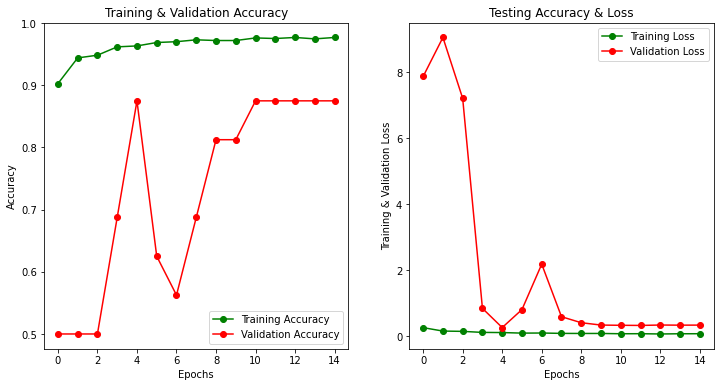

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """


1/1 [==============================] - 0s 233ms/step
              precision    recall  f1-score   support

      NORMAL       0.97      0.78      0.87       234
   PNEUMONIA       0.88      0.99      0.93       390

    accuracy                           0.91       624
   macro avg       0.93      0.88      0.90       624
weighted avg       0.92      0.91      0.91       624



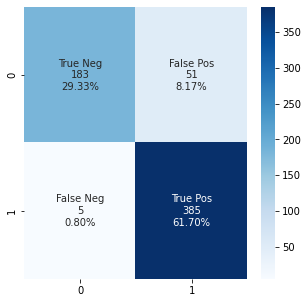

In [29]:
model1 = create_model()
history = model1.fit(aug_train_generator, epochs=epoch_size, validation_data=val_generator, callbacks = [learning_rate_reduction], verbose=0)
score = model1.evaluate(test_generator)
print("Test loss: " , score[0])
print("Test accuracy" , score[1])

create_plot(model1, history, epoch_size)

###with balanced and augmented training set

1/1 [==============================] - 0s 172ms/step - loss: 0.2400 - accuracy: 0.9263
Test loss:  0.24004711210727692
Test accuracy 0.9262820482254028


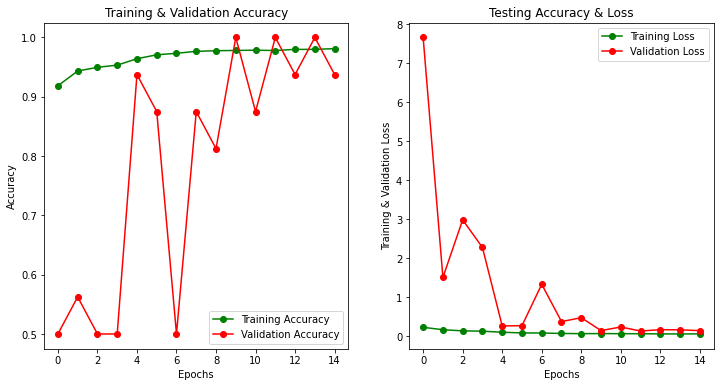

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """


1/1 [==============================] - 0s 246ms/step
              precision    recall  f1-score   support

      NORMAL       0.95      0.85      0.90       234
   PNEUMONIA       0.91      0.97      0.94       390

    accuracy                           0.93       624
   macro avg       0.93      0.91      0.92       624
weighted avg       0.93      0.93      0.93       624



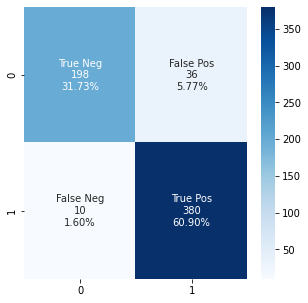

In [30]:
model2 = create_model()
history = model2.fit(balanced_train_generator, epochs = epoch_size , validation_data = val_generator, callbacks = [learning_rate_reduction], verbose=0)
score = model2.evaluate(test_generator)
print("Test loss: " , score[0])
print("Test accuracy" , score[1])

create_plot(model2, history, epoch_size)

###without augmentation (raw training set)

1/1 [==============================] - 0s 166ms/step - loss: 1.2229 - accuracy: 0.7708
Test loss:  1.2229410409927368
Test accuracy 0.7708333134651184


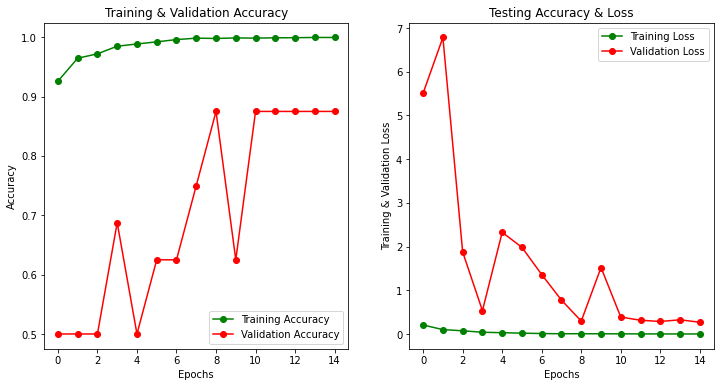

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """


1/1 [==============================] - 0s 236ms/step
              precision    recall  f1-score   support

      NORMAL       0.99      0.39      0.56       234
   PNEUMONIA       0.73      1.00      0.84       390

    accuracy                           0.77       624
   macro avg       0.86      0.70      0.70       624
weighted avg       0.83      0.77      0.74       624



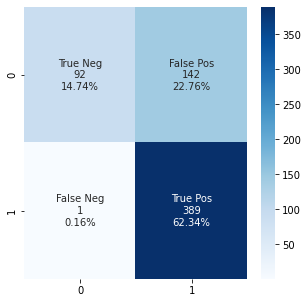

In [32]:
model3 = create_model()
history = model3.fit(raw_train_generator, epochs = epoch_size , validation_data = val_generator, callbacks = [learning_rate_reduction], verbose=0)
score = model3.evaluate(test_generator)
print("Test loss: " , score[0])
print("Test accuracy" , score[1])

create_plot(model3, history, epoch_size)

###ROC-curve analysis of CNN architectures

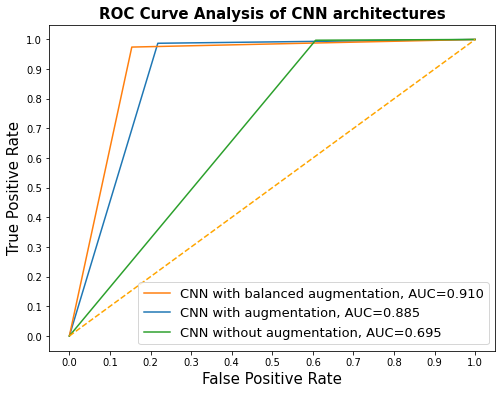

In [33]:
#@title
models = [model1, model2, model3]
model_names = ["CNN with augmentation", "CNN with balanced augmentation", "CNN without augmentation"]
from sklearn.metrics import roc_curve, roc_auc_score
roc_results = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

for model in models: 
    ypred = np.round(model.predict(test_generator,steps=len(test_generator),verbose=0))
    _, ytrue = test_generator.next()
    fpr, tpr, _ = roc_curve(ytrue,ypred)
    auc = roc_auc_score(ytrue, ypred)
    roc_results = roc_results.append({'classifiers': model_names[models.index(model)],
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

roc_results.set_index('classifiers', inplace=True)  

fig = plt.figure(figsize=(8,6))

for i in roc_results.index:
    plt.plot(roc_results.loc[i]['fpr'], 
             roc_results.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, roc_results.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis of CNN architectures', fontweight='bold', fontsize=15)
handles, labels = plt.gca().get_legend_handles_labels()

order = [1, 0, 2] #order by highest AUC score
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='lower right', prop={'size':13}) 
plt.show()

#Transfer learning

1.   ResNet50
2.   DenseNet121
3. VGG16
4. InceptionV3
5. Xception

when layers of pre-trained model are all trained, it reached highest acc, roc value      

In [ ]:
#@title evaluation_metrics
def metrics(model): 
    test_generator.reset()
    labels = ['NORMAL', 'PNEUMONIA']
    pred = model.predict(test_generator,steps=len(test_generator),verbose=1)
    ypred = np.round(pred)
    _, ytrue = test_generator.next()
    print(classification_report(ytrue, ypred, target_names=labels))
    
    conf_mat = confusion_matrix(ytrue, ypred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in conf_mat.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in conf_mat.flatten()/np.sum(conf_mat)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize=(5,5))
    sns.heatmap(conf_mat, annot=labels, fmt='', cmap='Blues')
    plt.show()

In [ ]:
#@title create_plot
def create_plot(model, history, epoch_size = epoch_size): 
    epochs = [i for i in range(epoch_size)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(12,6)

    ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
    ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
    ax[1].set_title('Testing Accuracy & Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")
    plt.show()
    #evaluation metric
    metrics(model)

In [ ]:
#@title create_pretrained
def create_pretrained(base_model):
  base_model.trainable = True #train all layers  
  inputs = base_model.input
  x = base_model.output
  x = Dense(128, activation='relu')(x)
  outputs = Dense(1, activation='sigmoid')(x)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
  return model 

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=0, factor=0.3, min_lr=0.000001)

In [ ]:
#@title run_pretrained
def run_pretrained(pre_trained_model ,train_generators): 
    model_loss = []
    model_acc = []
    for train_generator in tqdm(train_generators): 
        model = create_pretrained(pre_trained_model)
        model_history = model.fit(train_generator, validation_data=val_generator, epochs=epoch_size, verbose=0, callbacks=[learning_rate_reduction])
        loss, acc = model.evaluate(test_generator)
        model_loss.append(loss)
        model_acc.append(acc)
        create_plot(model, model_history)
    print(model_loss, model_acc)

In [ ]:
#three different training dataset
train_generators = [aug_train_generator, balanced_train_generator, raw_train_generator]

###ResNet50
[0.9439102411270142, 0.9455128312110901, 0.8141025900840759]

94781440/94765736 [==============================] - 2s 0us/step


  0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step - loss: 0.2152 - accuracy: 0.9439


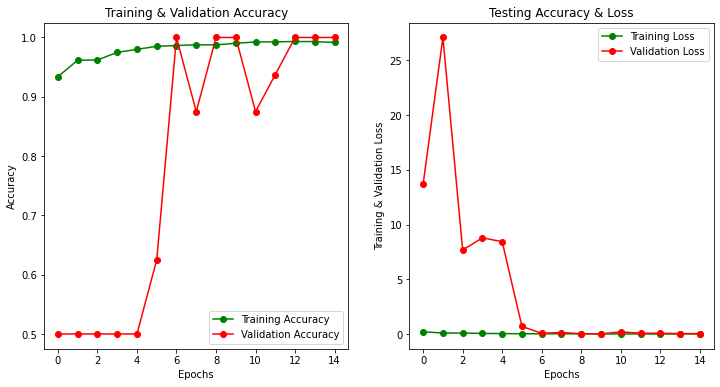

1/1 [==============================] - 1s 916ms/step
              precision    recall  f1-score   support

      NORMAL       0.97      0.88      0.92       234
   PNEUMONIA       0.93      0.98      0.96       390

    accuracy                           0.94       624
   macro avg       0.95      0.93      0.94       624
weighted avg       0.95      0.94      0.94       624



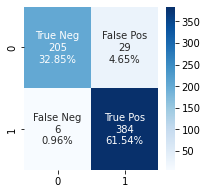

 33%|███▎      | 1/3 [04:41<09:22, 281.47s/it]

1/1 [==============================] - 0s 439ms/step - loss: 0.1720 - accuracy: 0.9455


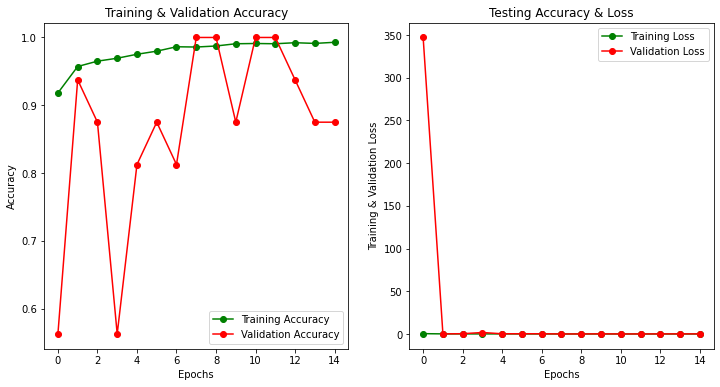

1/1 [==============================] - 1s 895ms/step
              precision    recall  f1-score   support

      NORMAL       0.93      0.92      0.93       234
   PNEUMONIA       0.95      0.96      0.96       390

    accuracy                           0.95       624
   macro avg       0.94      0.94      0.94       624
weighted avg       0.95      0.95      0.95       624



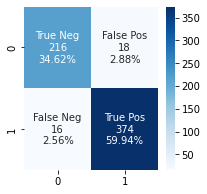

 67%|██████▋   | 2/3 [11:17<05:48, 348.85s/it]

1/1 [==============================] - 0s 443ms/step - loss: 1.4269 - accuracy: 0.8141


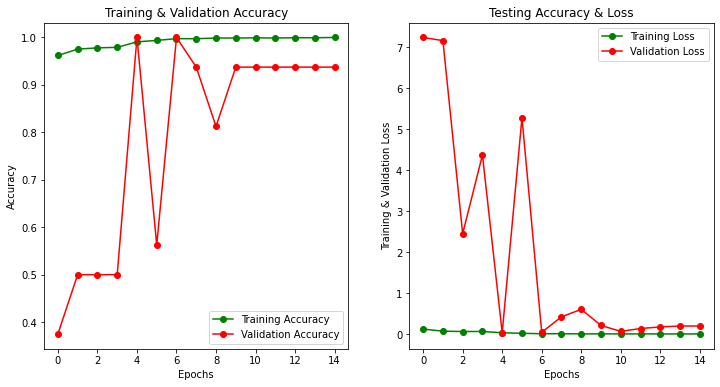

1/1 [==============================] - 1s 982ms/step
              precision    recall  f1-score   support

      NORMAL       0.99      0.51      0.67       234
   PNEUMONIA       0.77      1.00      0.87       390

    accuracy                           0.81       624
   macro avg       0.88      0.75      0.77       624
weighted avg       0.85      0.81      0.80       624



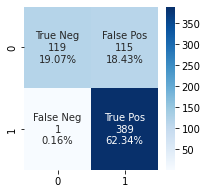

100%|██████████| 3/3 [14:36<00:00, 292.17s/it]

[0.21516036987304688, 0.17199547588825226, 1.4268718957901] [0.9439102411270142, 0.9455128312110901, 0.8141025900840759]


In [ ]:
#testing resnet50 with three different generators
resnet50 = ResNet50(input_shape=(img_size,img_size,3), include_top=False, weights='imagenet', pooling='max')
run_pretrained(resnet50, train_generators)

###DenseNet121
[0.9439102411270142, 0.9471153616905212, 0.8525640964508057]

29097984/29084464 [==============================] - 0s 0us/step


  0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step - loss: 0.2586 - accuracy: 0.9439


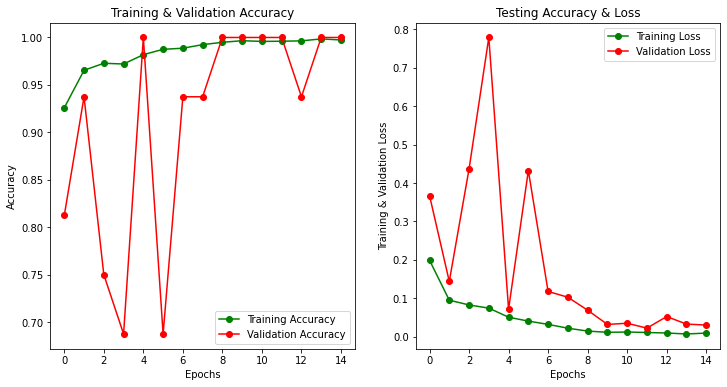

1/1 [==============================] - 2s 2s/step
              precision    recall  f1-score   support

      NORMAL       0.98      0.87      0.92       234
   PNEUMONIA       0.93      0.99      0.96       390

    accuracy                           0.94       624
   macro avg       0.95      0.93      0.94       624
weighted avg       0.95      0.94      0.94       624



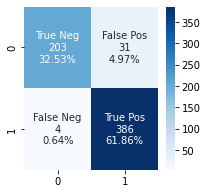

 33%|███▎      | 1/3 [04:41<09:23, 281.71s/it]

1/1 [==============================] - 0s 399ms/step - loss: 0.3573 - accuracy: 0.9471


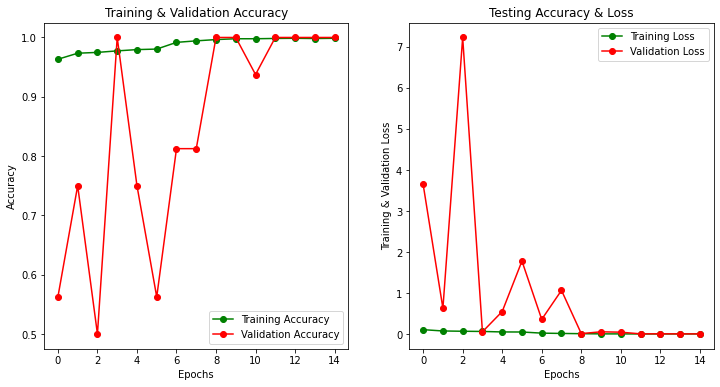

1/1 [==============================] - 2s 2s/step
              precision    recall  f1-score   support

      NORMAL       0.98      0.88      0.93       234
   PNEUMONIA       0.93      0.99      0.96       390

    accuracy                           0.95       624
   macro avg       0.96      0.93      0.94       624
weighted avg       0.95      0.95      0.95       624



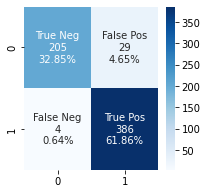

 67%|██████▋   | 2/3 [11:25<05:53, 353.39s/it]

1/1 [==============================] - 0s 397ms/step - loss: 1.1561 - accuracy: 0.8526


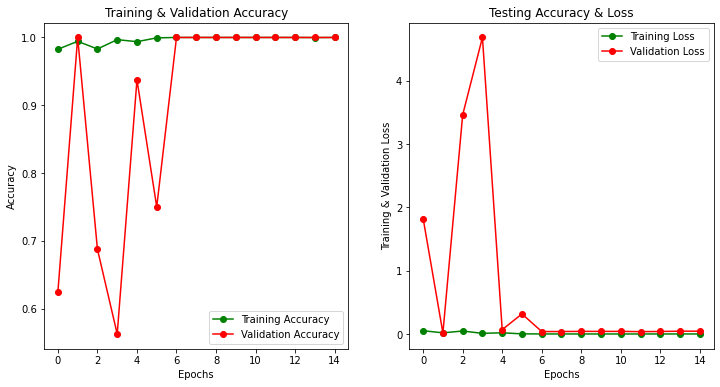

1/1 [==============================] - 2s 2s/step
              precision    recall  f1-score   support

      NORMAL       0.99      0.61      0.76       234
   PNEUMONIA       0.81      1.00      0.89       390

    accuracy                           0.85       624
   macro avg       0.90      0.80      0.83       624
weighted avg       0.88      0.85      0.84       624



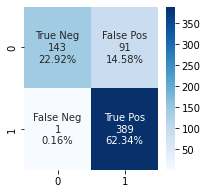

100%|██████████| 3/3 [15:01<00:00, 300.66s/it]

[0.25864312052726746, 0.3573285639286041, 1.1560739278793335] [0.9439102411270142, 0.9471153616905212, 0.8525640964508057]


In [ ]:
#testing densenet121 with three different generators
densenet121 = DenseNet121(input_shape=(img_size,img_size,3), include_top=False, weights='imagenet', pooling='max')
run_pretrained(densenet121, train_generators)

###VGG16
[0.8685897588729858, 0.9038461446762085, 0.7676281929016113]

58900480/58889256 [==============================] - 0s 0us/step


  0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 10s 10s/step - loss: 0.4297 - accuracy: 0.8686


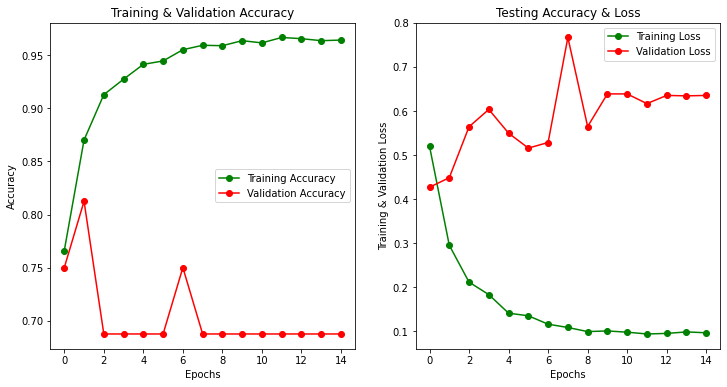

1/1 [==============================] - 0s 245ms/step
              precision    recall  f1-score   support

      NORMAL       0.95      0.69      0.80       234
   PNEUMONIA       0.84      0.98      0.90       390

    accuracy                           0.87       624
   macro avg       0.89      0.83      0.85       624
weighted avg       0.88      0.87      0.86       624



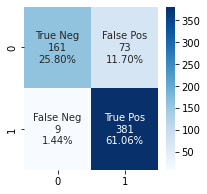

 33%|███▎      | 1/3 [04:28<08:57, 268.98s/it]

1/1 [==============================] - 1s 549ms/step - loss: 0.4140 - accuracy: 0.9038


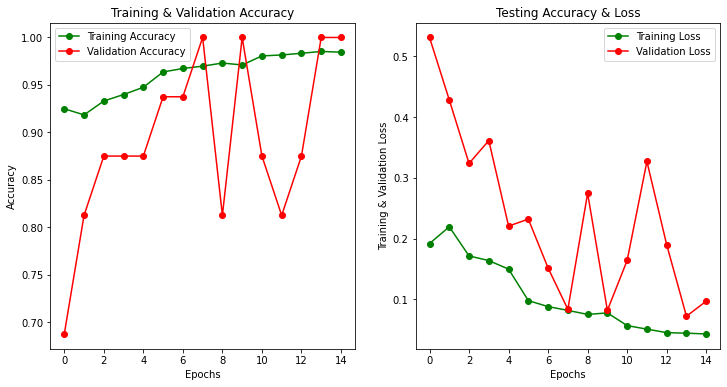

1/1 [==============================] - 0s 249ms/step
              precision    recall  f1-score   support

      NORMAL       0.97      0.76      0.86       234
   PNEUMONIA       0.88      0.99      0.93       390

    accuracy                           0.90       624
   macro avg       0.92      0.88      0.89       624
weighted avg       0.91      0.90      0.90       624



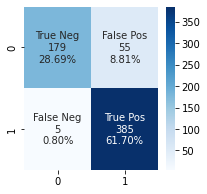

 67%|██████▋   | 2/3 [10:55<05:38, 338.01s/it]

1/1 [==============================] - 1s 548ms/step - loss: 2.7321 - accuracy: 0.7676


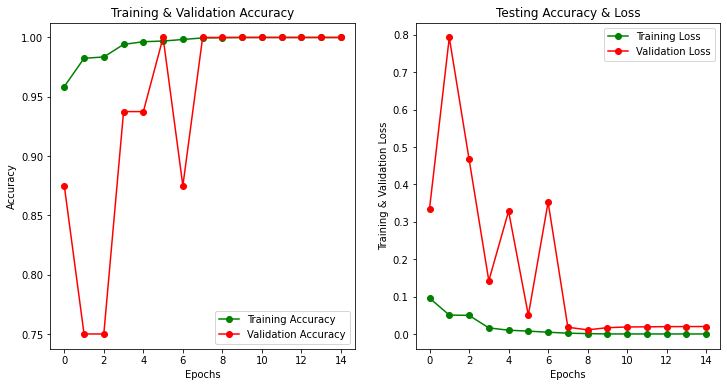

1/1 [==============================] - 0s 247ms/step
              precision    recall  f1-score   support

      NORMAL       0.98      0.39      0.56       234
   PNEUMONIA       0.73      0.99      0.84       390

    accuracy                           0.77       624
   macro avg       0.85      0.69      0.70       624
weighted avg       0.82      0.77      0.74       624



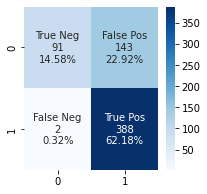

100%|██████████| 3/3 [14:03<00:00, 281.20s/it]

[0.42974844574928284, 0.4140452444553375, 2.7321157455444336] [0.8685897588729858, 0.9038461446762085, 0.7676281929016113]


In [ ]:
#testing VGG16 with three different generators
vgg16 = VGG16(input_shape=(img_size,img_size,3), include_top=False, weights='imagenet', pooling='max')
run_pretrained(vgg16, train_generators)

###Inception-V3
 [0.9134615659713745, 0.9439102411270142, 0.7948718070983887]

87924736/87910968 [==============================] - 0s 0us/step


  0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step - loss: 0.2419 - accuracy: 0.9135


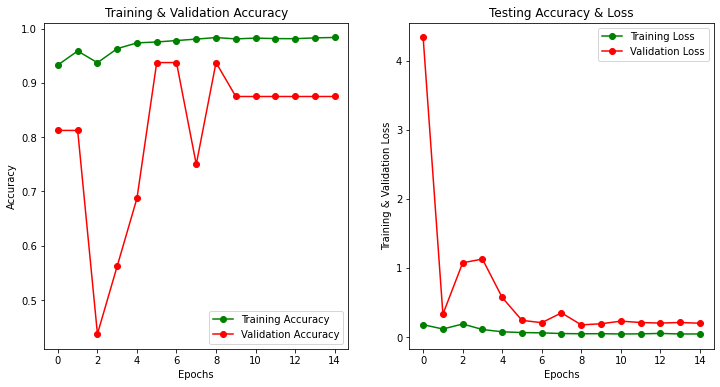

1/1 [==============================] - 1s 1s/step
              precision    recall  f1-score   support

      NORMAL       0.99      0.78      0.87       234
   PNEUMONIA       0.88      0.99      0.93       390

    accuracy                           0.91       624
   macro avg       0.94      0.89      0.90       624
weighted avg       0.92      0.91      0.91       624



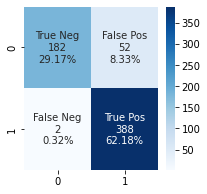

 33%|███▎      | 1/3 [04:31<09:02, 271.36s/it]

1/1 [==============================] - 0s 314ms/step - loss: 0.2329 - accuracy: 0.9439


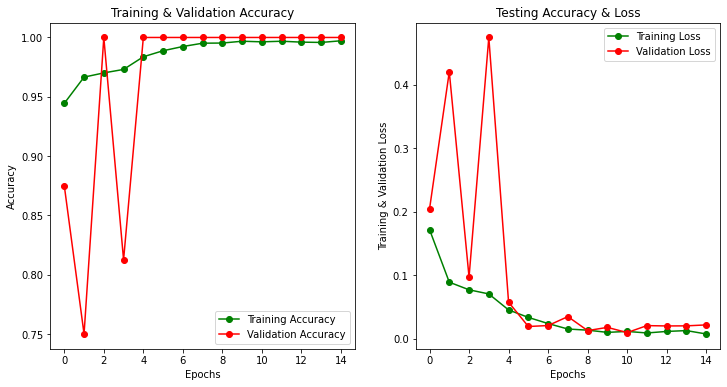

1/1 [==============================] - 1s 1s/step
              precision    recall  f1-score   support

      NORMAL       0.99      0.86      0.92       234
   PNEUMONIA       0.92      0.99      0.96       390

    accuracy                           0.94       624
   macro avg       0.95      0.93      0.94       624
weighted avg       0.95      0.94      0.94       624



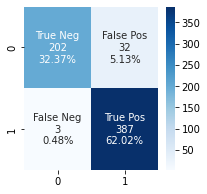

 67%|██████▋   | 2/3 [11:11<05:47, 347.32s/it]

1/1 [==============================] - 0s 314ms/step - loss: 0.8042 - accuracy: 0.7949


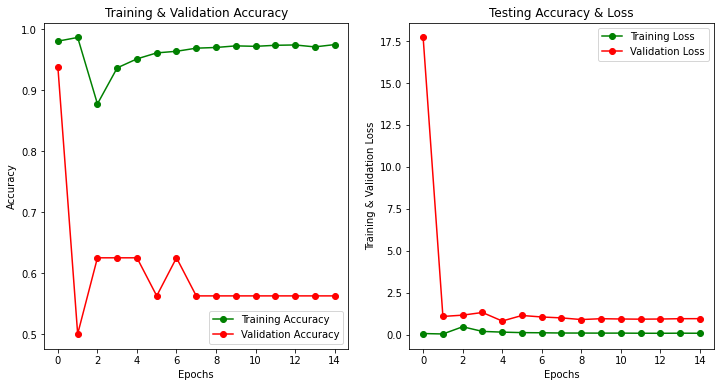

1/1 [==============================] - 1s 1s/step
              precision    recall  f1-score   support

      NORMAL       0.96      0.47      0.63       234
   PNEUMONIA       0.76      0.99      0.86       390

    accuracy                           0.79       624
   macro avg       0.86      0.73      0.74       624
weighted avg       0.83      0.79      0.77       624



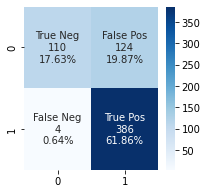

100%|██████████| 3/3 [14:17<00:00, 285.73s/it]

[0.24190670251846313, 0.23287895321846008, 0.8041701912879944] [0.9134615659713745, 0.9439102411270142, 0.7948718070983887]


In [ ]:
inception = InceptionV3(input_shape=(img_size,img_size,3), include_top=False, weights='imagenet', pooling='max')
run_pretrained(inception, train_generators)

In [ ]:
best_acc_index = inception_models_acc.index(max(inception_models_acc))
inception = inception_models[best_acc_index] #designate model with best acc to represent the model 

###XCeption
[0.9375, 0.9519230723381042, 0.8092948794364929]

83697664/83683744 [==============================] - 1s 0us/step


  0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step - loss: 0.2294 - accuracy: 0.9375


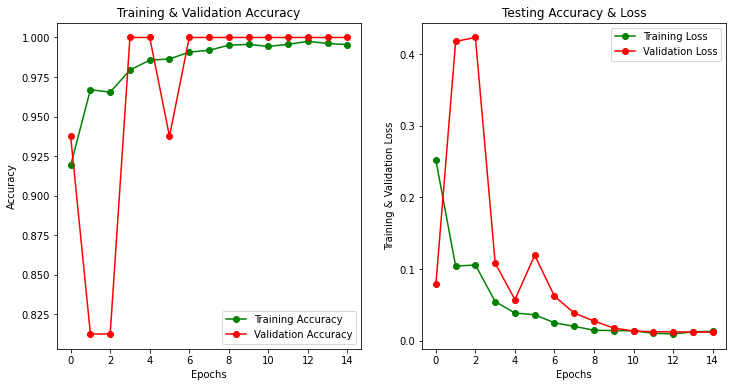

1/1 [==============================] - 1s 783ms/step
              precision    recall  f1-score   support

      NORMAL       0.98      0.85      0.91       234
   PNEUMONIA       0.92      0.99      0.95       390

    accuracy                           0.94       624
   macro avg       0.95      0.92      0.93       624
weighted avg       0.94      0.94      0.94       624



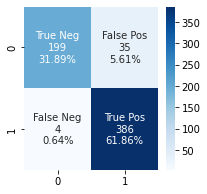

 33%|███▎      | 1/3 [05:27<10:55, 327.54s/it]

1/1 [==============================] - 1s 522ms/step - loss: 0.2899 - accuracy: 0.9519


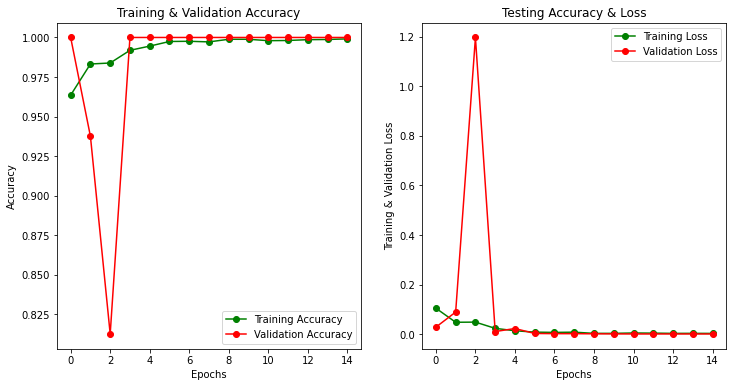

1/1 [==============================] - 1s 766ms/step
              precision    recall  f1-score   support

      NORMAL       0.97      0.90      0.93       234
   PNEUMONIA       0.94      0.98      0.96       390

    accuracy                           0.95       624
   macro avg       0.96      0.94      0.95       624
weighted avg       0.95      0.95      0.95       624



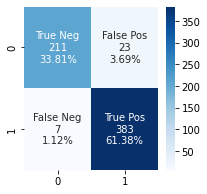

 67%|██████▋   | 2/3 [13:26<06:56, 416.79s/it]

1/1 [==============================] - 1s 520ms/step - loss: 1.5381 - accuracy: 0.8093


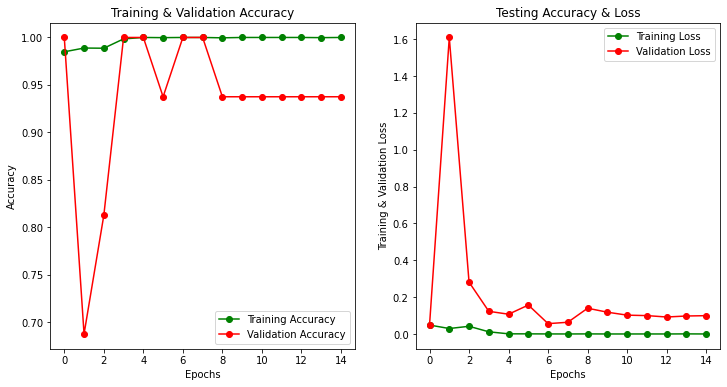

1/1 [==============================] - 1s 767ms/step
              precision    recall  f1-score   support

      NORMAL       0.99      0.50      0.66       234
   PNEUMONIA       0.77      1.00      0.87       390

    accuracy                           0.81       624
   macro avg       0.88      0.75      0.76       624
weighted avg       0.85      0.81      0.79       624



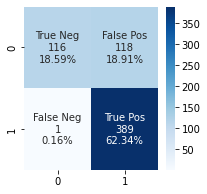

100%|██████████| 3/3 [18:51<00:00, 377.13s/it]

[0.22939433157444, 0.2899494767189026, 1.5381042957305908] [0.9375, 0.9519230723381042, 0.8092948794364929]


In [ ]:
xception = Xception(input_shape=(img_size,img_size,3), include_top=False, weights='imagenet', pooling='max')
run_pretrained(xception, train_generators)

##ROC curve analysis of TL models, using *balanced and augmented dataset *

In [ ]:
#@title testing pre-trained model w/ balanced_train_generator
TL_model_list = [ResNet50, DenseNet121, VGG16, InceptionV3, Xception]
TL_model_names = ["resnet50", "densenet121", "vgg16", "inception", 'xception']

roc_results = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

for TL_model in TL_model_list: 
    model = TL_model(input_shape=(img_size,img_size,3), include_top=False, weights='imagenet', pooling='max')
    model = create_pretrained(model)
    model_history = model.fit(balanced_train_generator, validation_data=val_generator, epochs=epoch_size, verbose=0, callbacks=[learning_rate_reduction])
    #evaluate test set 
    ypred = np.round(model.predict(test_generator,steps=len(test_generator),verbose=0))
    _, ytrue = test_generator.next()
    fpr, tpr, _ = roc_curve(ytrue,ypred)
    auc = roc_auc_score(ytrue, ypred)
    roc_results = roc_results.append({'classifiers': TL_model_names[TL_model_list.index(TL_model)],
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

83697664/83683744 [==============================] - 0s 0us/step


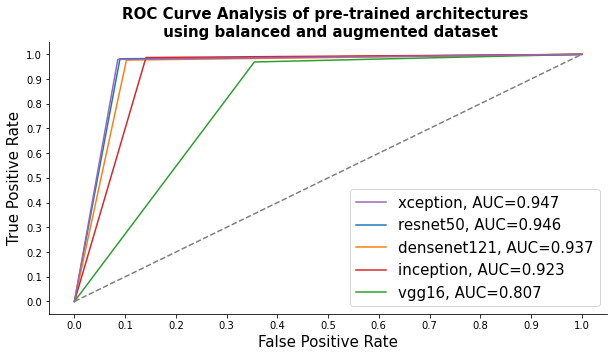

In [ ]:
#@title plot ROC curve
roc_results.set_index('classifiers', inplace=True)  

fig, ax =  plt.subplots(figsize = (10, 5))
    
for i in roc_results.index:
    plt.plot(roc_results.loc[i]['fpr'], 
             roc_results.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, roc_results.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='gray', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis of pre-trained architectures \n using balanced and augmented dataset', fontweight='bold', fontsize=15)
handles, labels = plt.gca().get_legend_handles_labels()
order = [4,0,1,3,2] #order by highest AUC score
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='lower right', prop={'size':15}) 

for s in ["top","right"]:
    ax.spines[s].set_visible(False)

plt.show()


In [ ]:
#@title
# TL_models = [resnet50, densenet121, vgg16, inception, xception] #best performing model from each classifer is saved in this TL_models list 

# #@title

# TL_model_names = ["resnet50", "densenet121", "vgg16", "inception", 'xception']
# roc_results = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# for model in TL_models: 
#     ypred = np.round(model.predict(test_generator,steps=len(test_generator),verbose=0))
#     _, ytrue = test_generator.next()
#     fpr, tpr, _ = roc_curve(ytrue,ypred)
#     auc = roc_auc_score(ytrue, ypred)
#     roc_results = roc_results.append({'classifiers': TL_model_names[TL_models.index(model)],
#                                         'fpr':fpr, 
#                                         'tpr':tpr, 
#                                         'auc':auc}, ignore_index=True)

# roc_results.set_index('classifiers', inplace=True)  

# fig = plt.figure(figsize=(8,6))

# for i in roc_results.index:
#     plt.plot(roc_results.loc[i]['fpr'], 
#              roc_results.loc[i]['tpr'], 
#              label="{}, AUC={:.3f}".format(i, roc_results.loc[i]['auc']))
    
# plt.plot([0,1], [0,1], color='orange', linestyle='--')

# plt.xticks(np.arange(0.0, 1.1, step=0.1))
# plt.xlabel("Flase Positive Rate", fontsize=15)

# plt.yticks(np.arange(0.0, 1.1, step=0.1))
# plt.ylabel("True Positive Rate", fontsize=15)

# plt.title('ROC Curve Analysis of CNN architectures', fontweight='bold', fontsize=15)
# handles, labels = plt.gca().get_legend_handles_labels()
# plt.legend(loc='lower right', prop={'size':13}) 
# # order = [1, 0, 2] #order by highest AUC score
# # plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='lower right', prop={'size':13}) 
# plt.show()

#loss and acc of architectures for three diff dataset

In [ ]:
#@title loss, acc values
### test loss and acc graph : couldn't run all models in one running time due to RAM shortage so done manually 

cnn_loss = [0.23861698806285858, 0.2704387903213501, 1.6238915920257568]
cnn_acc = [0.9230769276618958, 0.9294871687889099, 0.7403846383094788]
resnet_loss = [0.21516036987304688, 0.17199547588825226, 1.4268718957901] 
resnet_acc = [0.9439102411270142, 0.9455128312110901, 0.8141025900840759]
desnet_loss = [0.25864312052726746, 0.3573285639286041, 1.1560739278793335] 
desnet_acc = [0.9439102411270142, 0.9471153616905212, 0.8525640964508057]
vgg_loss = [0.42974844574928284, 0.4140452444553375, 2.7321157455444336] 
vgg_acc = [0.8685897588729858, 0.9038461446762085, 0.7676281929016113]
inception_loss = [0.24190670251846313, 0.23287895321846008, 0.8041701912879944] 
inception_acc = [0.9134615659713745, 0.9439102411270142, 0.7948718070983887]
xception_loss = [0.22939433157444, 0.2899494767189026, 1.5381042957305908] 
xception_acc = [0.9375, 0.9519230723381042, 0.8092948794364929]

model_names = ["CNN", "ResNet50", "DenseNet121", "VGG16", "InceptionV3", "Xception"]
loss_list = [cnn_loss, resnet_loss, desnet_loss, vgg_loss, inception_loss, xception_loss]
acc_list = [cnn_acc, resnet_acc, desnet_acc, vgg_acc, inception_acc, xception_acc]

results = pd.DataFrame(columns=['classifiers', 'no augmentation','balanced & augmentation','augmentation'])

In [ ]:
#@title plot_model_results
def plot_model_results(model_names, value_type, list_type):
    results = pd.DataFrame()
    for model in model_names: 
      i = model_names.index(model)
      results = results.append({'classifiers': model,
                                'no augmentation':list_type[i][2], 
                                'balanced & augmentation':list_type[i][1], 
                                'with augmentation':list_type[i][0]}, ignore_index=True)
    if value_type == "loss": 
      results = results.sort_values(by=['no augmentation'], ascending=False) 
    else: 
      results = results.sort_values(by=['balanced & augmentation'], ascending=False) 
    results.set_index('classifiers', inplace=True)  
    fig, ax =  plt.subplots(figsize = (10, 10))  
    for i in results.index:
        plt.plot(results.columns, 
                results.loc[i], 
                label="{}, values=[{:.3f}, {:.3f}, {:.3}]".format(i, results.loc[i]['no augmentation'], results.loc[i]['balanced & augmentation'], results.loc[i]['with augmentation']))  

    if value_type == "loss": 
      plt.yticks(np.arange(0, results.max().max(), step=0.5)) #highest number in no augmentation loss value 
    else: 
      plt.yticks(np.arange(0.7, results.max().max() + 0.1, step=0.1)) #highest number in balanced*augmented acc value 
    plt.xticks(fontsize=14)
    plt.xlabel("Dataset types", fontsize=15)
    plt.ylabel("Test {}".format(value_type), fontsize=15)
    plt.legend(prop={'size':14}) 

    for s in ["top","right"]:
        ax.spines[s].set_visible(False)
    plt.show()

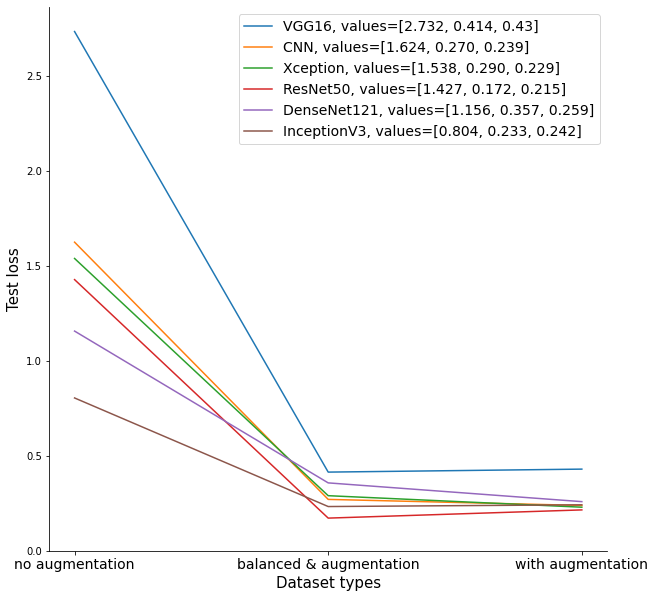

In [ ]:
plot_model_results(model_names, "loss", loss_list)

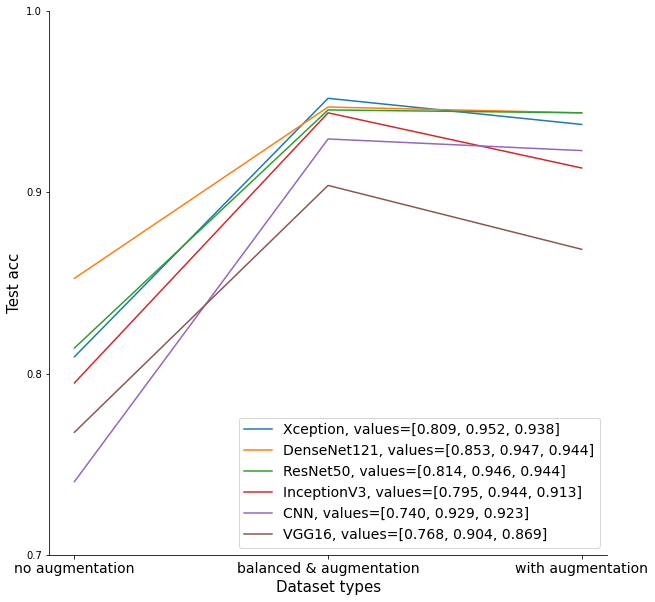

In [ ]:
plot_model_results(model_names, "acc", acc_list)

#Visualize feature maps

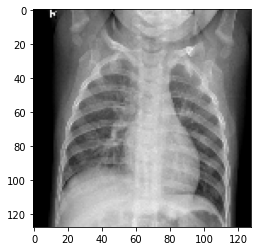

In [101]:
#img to use 
img = np.expand_dims(p_train[0], axis=0)
plt.imshow(img[0])
plt.show()

In [99]:
#@title show_featuremaps
np.seterr(divide='ignore', invalid='ignore')

def show_featuremaps(model, img, layer_num, n_col = 10, n_row = 1): 
    outputs = [model.layers[i+1].output for i in layer_num]
    layer_names = [model.layers[i].name for i in layer_num]
    activation_model = models.Model(inputs=model.input, outputs=outputs)
    feature_maps = activation_model.predict(img)

    for layer_name, fmap in zip(layer_names, feature_maps):
      plt.figure(figsize=(15, 10))
      # plot n_row x n_col number of maps
      ix = 1
      for _ in range(n_row):
        for _ in range(n_col):
          # specify subplot and turn off axis
          ax = plt.subplot(n_row, n_col, ix)
          ax.set_xticks([])
          ax.set_yticks([])
          # Post-process the feature to make it visually palatable to human eyes: standardization and normalization 
          channel_image = fmap[0, :, :, ix-1]
          channel_image -= channel_image.mean()
          channel_image /= channel_image.std()
          channel_image *= 64 
          channel_image += 128 
          channel_image = np.clip(channel_image, 0, 255).astype('uint8')
          plt.imshow(channel_image, cmap='viridis')
          ix += 1
      plt.title(layer_name)
      plt.show()

In [83]:
model = VGG16(input_shape=(128,128,3), include_top=False, weights='imagenet', pooling='max')
for i, layer in enumerate(model.layers):
   print(i, layer.name)

0 input_16
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
19 global_max_pooling2d_12


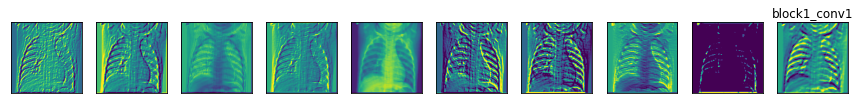

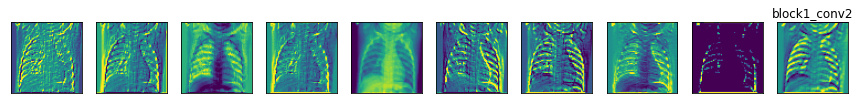

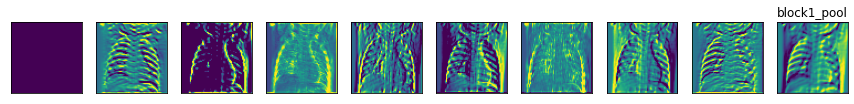

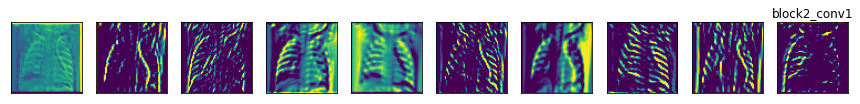

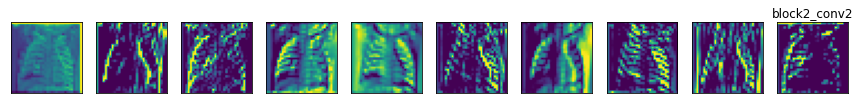

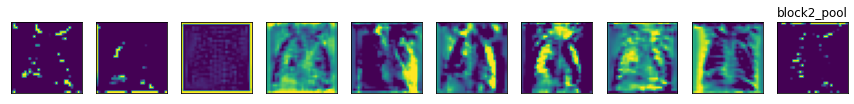

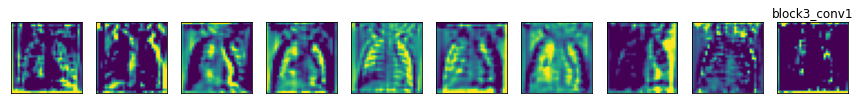

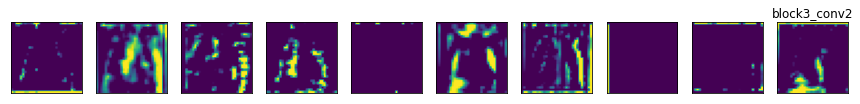

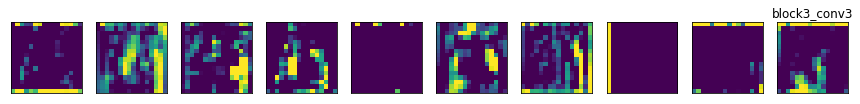

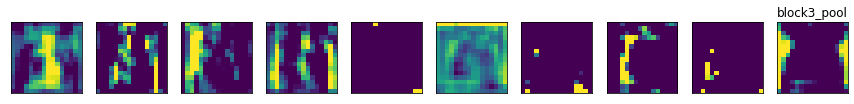

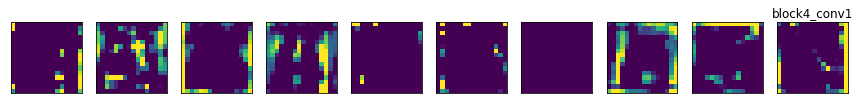

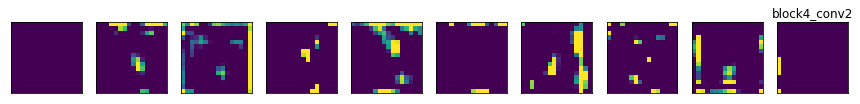

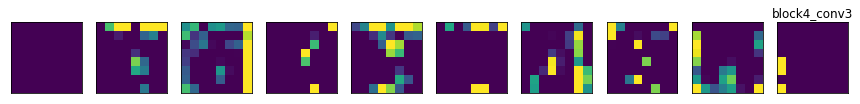

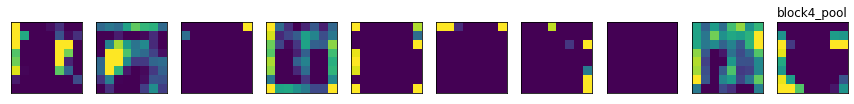

In [100]:
layer_num = list(range(1,15)) #[1,4,8,14] #number (nth) of layer to be printed
show_featuremaps(model, img_tensor, layer_num, n_col = 10, n_row = 1)

#.

#Visualization of activation layers (intpretation of intermediate layers) 

-as we move onto deeper layers inside neural network, we are learning mroe abstract features. few layers concentrate on few features of the image. and those features will be combined together in the next subsequent layer 
-as we go deeper inside neural network, things become quite complicated and can't interpret what neural network is doing in the higher convolutional layers. Higher layers are trying to learn the complex features from the image which are required to classify whether the given image is pneumonia or normal. Some filters are in violet colors. these filters dont held any data to learn the new things.  we can check what intermediate, controuing layer and max pooling layer has learned from the input image. 

In [6]:
img_size = 128
batch_size = 32
epoch_size = 15
model = VGG16(input_shape=(img_size,img_size,3), include_top=False, weights='imagenet', pooling='max')

58900480/58889256 [==============================] - 1s 0us/step


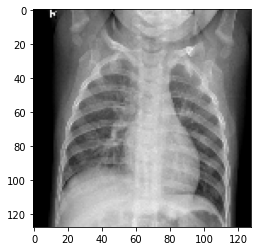

In [7]:
# sample image: importing first image in the "pneumonia class" training set 
img_tensor = np.expand_dims(p_train[0], axis=0)
plt.imshow(img_tensor[0])
plt.show()

In [8]:
for i, layer in enumerate(model.layers[1:]):
   print(i, layer.name)

0 block1_conv1
1 block1_conv2
2 block1_pool
3 block2_conv1
4 block2_conv2
5 block2_pool
6 block3_conv1
7 block3_conv2
8 block3_conv3
9 block3_pool
10 block4_conv1
11 block4_conv2
12 block4_conv3
13 block4_pool
14 block5_conv1
15 block5_conv2
16 block5_conv3
17 block5_pool
18 global_max_pooling2d


In [9]:
from keras import models
# Extracts the outputs of the top layers everything upto the GAP layer:
layer_outputs = [layer.output for layer in model.layers[1:5]] #this model has 18 layers just before the GAP layer

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

# This will return a list of Numpy arrays: one array per layer activation
activations = activation_model.predict(img_tensor)


In [ ]:
#@title 
# from keras import models
# # Extracts the outputs of the top layers everything upto the GAP layer:
# layer_outputs = [layer.output for layer in model.layers[1:10]] #this model has 18 layers just before the GAP layer

# # Creates a model that will return these outputs, given the model input:
# activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
# # This will return a list of Numpy arrays: one array per layer activation
# activations = activation_model.predict(img_tensor)

# # This is the activation of the first convolution layer for our image input:
# second_layer_activation = activations[1]
# print(second_layer_activation.shape) #(1, 300, 300, 64)

# #It's a 300*300 feature map with 64 channels. Visualizing the 60th and 10th channel:
# plt.matshow(second_layer_activation[0, :, :, 0], cmap='gray')
# plt.show()

# #This channel appears to encode a diagonal edge detector. 
# # 10th channel, since the specific filters learned by convolution layers are not deterministic.
# plt.matshow(second_layer_activation[0, :, :, 1], cmap='gray')
# plt.show()

# for i in range(10): 
#   plt.matshow(second_layer_activation[0, :, :, i], cmap='gray')
#   plt.show()

64
64
64
128


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


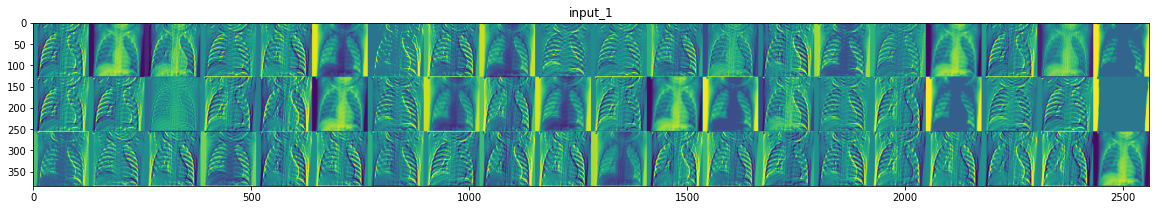

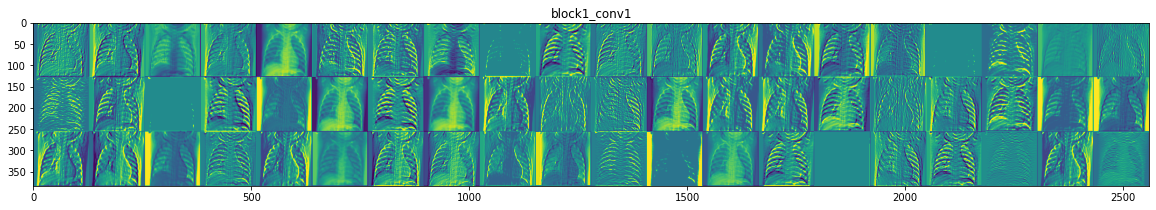

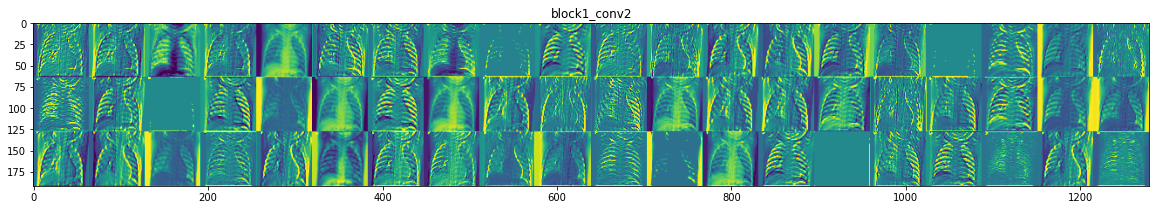

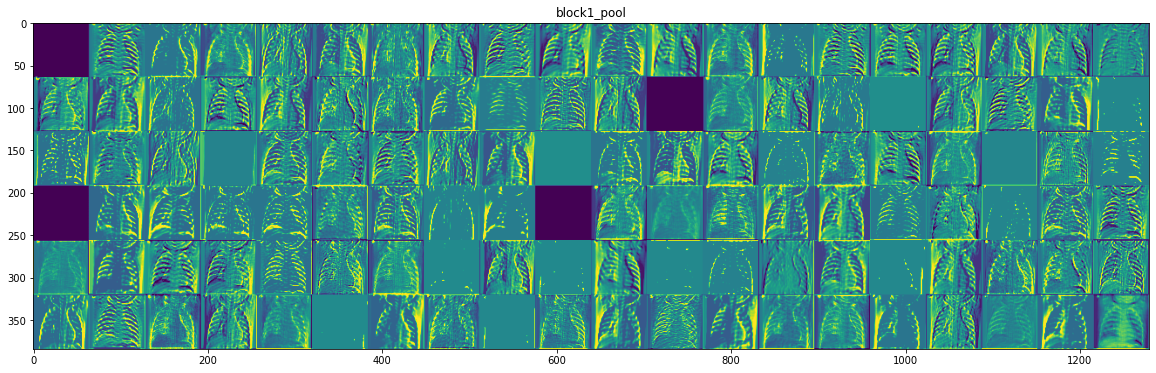

In [12]:
# Names of the layers to have them as part of the plot
layer_names = []
for layer in model.layers:
    layer_names.append(layer.name)

images_per_row = 20 

# Display feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]
    print(n_features)
    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # Tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # Tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64 
            channel_image += 128 
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(int(scale * display_grid.shape[1]),
                        int(scale * display_grid.shape[0])))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

In [ ]:
scale * display_grid.shape[1]

20.0

In [ ]:
scale * display_grid.shape[0]

0.0